In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import joblib
import json
import os

In [2]:
STOCKS = ["CGH", "LICN", "NABIL", "NIFRA", "UPPER"]
DATA_DIR = "data"
MODEL_DIR = "models"
METRIC_DIR = "metrics"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRIC_DIR, exist_ok=True)


In [3]:
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)


def clean_close_series(df):
    if "close" not in df.columns:
        raise ValueError("Expected a 'close' column in the dataset")
    close = pd.to_numeric(df["close"], errors="coerce")
    close = close.interpolate(method="linear").ffill().bfill()
    close = close.dropna()
    return close.values.reshape(-1, 1)


def split_time_series(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    X_train = X[:train_end]
    y_train = y[:train_end]
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    X_test = X[val_end:]
    y_test = y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
for stock in STOCKS:
    print(f"\nTraining LSTM for {stock}")

    df = pd.read_csv(f"{DATA_DIR}/{stock}.csv")
    close_prices = clean_close_series(df)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close_prices)

    X, y = create_sequences(scaled)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series(X, y)

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    model.save(f"{MODEL_DIR}/{stock}_lstm.h5")
    joblib.dump(scaler, f"{MODEL_DIR}/{stock}_scaler.pkl")

    history_payload = {
        "loss": [float(v) for v in history.history.get("loss", [])],
        "val_loss": [float(v) for v in history.history.get("val_loss", [])],
        "final_loss": float(history.history["loss"][-1]),
        "final_val_loss": float(history.history["val_loss"][-1]),
        "generalization_gap": float(history.history["val_loss"][-1] - history.history["loss"][-1])
    }
    with open(f"{METRIC_DIR}/{stock}_loss.json", "w") as f:
        json.dump(history_payload, f)

    # Save regression curve + error trend on test split
    preds = model.predict(X_test)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predicted = scaler.inverse_transform(preds).flatten()
    errors = actual - predicted

    pd.DataFrame({
        "actual": actual.tolist(),
        "predicted": predicted.tolist()
    }).to_json(f"{METRIC_DIR}/{stock}_regression_curve.json")

    pd.DataFrame({
        "actual": actual.tolist(),
        "predicted": predicted.tolist(),
        "error": errors.tolist()
    }).to_json(f"{METRIC_DIR}/{stock}_error_trend.json")

    regression_metrics = {
        "mse": float(mean_squared_error(actual, predicted)),
        "rmse": float(np.sqrt(mean_squared_error(actual, predicted))),
        "mae": float(mean_absolute_error(actual, predicted)),
        "r2": float(r2_score(actual, predicted))
    }
    with open(f"{METRIC_DIR}/{stock}_regression_metrics.json", "w") as f:
        json.dump(regression_metrics, f)


Training LSTM for CGH


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

Training LSTM for LICN


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

Training LSTM for NABIL


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Training LSTM for NIFRA


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

Training LSTM for UPPER


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [5]:
CV_SPLITS = 3
CV_EPOCHS = 10

for stock in STOCKS:
    print(f"\nTime-series CV (LSTM) for {stock}")

    df = pd.read_csv(f"{DATA_DIR}/{stock}.csv")
    close_prices = clean_close_series(df)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close_prices)

    X, y = create_sequences(scaled)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
    folds = []

    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mse")
        model.fit(
            X_train, y_train,
            epochs=CV_EPOCHS,
            batch_size=32,
            verbose=0
        )

        preds = model.predict(X_test, verbose=0)
        actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        predicted = scaler.inverse_transform(preds).flatten()

        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)

        folds.append({
            "fold": fold_idx,
            "mse": float(mse),
            "rmse": float(rmse),
            "mae": float(mae),
            "r2": float(r2)
        })

    means = {
        "mse": float(np.mean([f["mse"] for f in folds])),
        "rmse": float(np.mean([f["rmse"] for f in folds])),
        "mae": float(np.mean([f["mae"] for f in folds])),
        "r2": float(np.mean([f["r2"] for f in folds]))
    }

    payload = {
        "folds": folds,
        "mean": means
    }

    with open(f"{METRIC_DIR}/{stock}_lstm_cv.json", "w") as f:
        json.dump(payload, f)
    
    model.summary()


Time-series CV (LSTM) for CGH


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)


Time-series CV (LSTM) for LICN


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)


Time-series CV (LSTM) for NABIL


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)


Time-series CV (LSTM) for NIFRA


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)


Time-series CV (LSTM) for UPPER


c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\samaw\Desktop\project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

In [6]:
from tensorflow.keras.models import load_model

FORECAST_DAYS = 30

for stock in STOCKS:
    df = pd.read_csv(f"{DATA_DIR}/{stock}.csv")
    close = df["close"].values.reshape(-1, 1)

    scaler = joblib.load(f"{MODEL_DIR}/{stock}_scaler.pkl")
    model = load_model(f"{MODEL_DIR}/{stock}_lstm.h5", compile=False)

    scaled = scaler.transform(close)
    window = scaled[-60:].reshape(1, 60, 1)

    preds = []
    for _ in range(FORECAST_DAYS):
        next_scaled = model.predict(window, verbose=0)[0][0]
        preds.append(next_scaled)
        next_step = np.array(next_scaled).reshape(1, 1, 1)
        window = np.concatenate([window[:, 1:, :], next_step], axis=1)

    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    out = pd.DataFrame({
        "day": list(range(1, FORECAST_DAYS + 1)),
        "predicted_price": preds_inv
    })
    out.to_csv(f"{MODEL_DIR}/{stock}_30day_forecast.csv", index=False)

print("Saved 30-day forecasts to models/")

Saved 30-day forecasts to models/


In [7]:
def create_labels(prices):
    return (prices[1:] > prices[:-1]).astype(int)


In [8]:
for stock in STOCKS:
    print(f"\nTraining classifier for {stock}")

    df = pd.read_csv(f"{DATA_DIR}/{stock}.csv")
    prices = clean_close_series(df).flatten()

    X = prices[:-1].reshape(-1, 1)
    y = create_labels(prices)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42
    )
    clf.fit(X_train, y_train)

    joblib.dump(clf, f"{MODEL_DIR}/{stock}_rf.pkl")

    # Predictions
    probs = clf.predict_proba(X_test)[:, 1]
    preds = clf.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    with open(f"{METRIC_DIR}/{stock}_confusion.json", "w") as f:
        json.dump({
            "matrix": cm.tolist(),
            "labels": ["DOWN", "UP"]
        }, f)

    # ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    with open(f"{METRIC_DIR}/{stock}_roc.json", "w") as f:
        json.dump({
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": float(roc_auc)
        }, f)

    # Classification metrics
    metrics_payload = {
        "accuracy": float(accuracy_score(y_test, preds)),
        "precision": float(precision_score(y_test, preds, zero_division=0)),
        "recall": float(recall_score(y_test, preds, zero_division=0)),
        "f1": float(f1_score(y_test, preds, zero_division=0))
    }
    with open(f"{METRIC_DIR}/{stock}_classification_metrics.json", "w") as f:
        json.dump(metrics_payload, f)

    report = classification_report(y_test, preds, target_names=["DOWN", "UP"], output_dict=True, zero_division=0)
    with open(f"{METRIC_DIR}/{stock}_classification_report.json", "w") as f:
        json.dump(report, f)

    print(f"AUC for {stock}: {roc_auc:.3f}")


Training classifier for CGH
AUC for CGH: 0.502

Training classifier for LICN
AUC for LICN: 0.481

Training classifier for NABIL
AUC for NABIL: 0.499

Training classifier for NIFRA
AUC for NIFRA: 0.426

Training classifier for UPPER
AUC for UPPER: 0.421


In [9]:
CV_SPLITS = 3

for stock in STOCKS:
    print(f"\nTime-series CV (RF) for {stock}")

    df = pd.read_csv(f"{DATA_DIR}/{stock}.csv")
    prices = clean_close_series(df).flatten()

    X = prices[:-1].reshape(-1, 1)
    y = create_labels(prices)

    tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
    folds = []

    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = RandomForestClassifier(
            n_estimators=200,
            max_depth=5,
            random_state=42
        )
        clf.fit(X_train, y_train)

        preds = clf.predict(X_test)
        probs = clf.predict_proba(X_test)[:, 1]

        if len(np.unique(y_test)) < 2:
            roc_auc = float("nan")
        else:
            fpr, tpr, _ = roc_curve(y_test, probs)
            roc_auc = auc(fpr, tpr)

        folds.append({
            "fold": fold_idx,
            "accuracy": float(accuracy_score(y_test, preds)),
            "precision": float(precision_score(y_test, preds, zero_division=0)),
            "recall": float(recall_score(y_test, preds, zero_division=0)),
            "f1": float(f1_score(y_test, preds, zero_division=0)),
            "auc": float(roc_auc)
        })

    means = {
        "accuracy": float(np.nanmean([f["accuracy"] for f in folds])),
        "precision": float(np.nanmean([f["precision"] for f in folds])),
        "recall": float(np.nanmean([f["recall"] for f in folds])),
        "f1": float(np.nanmean([f["f1"] for f in folds])),
        "auc": float(np.nanmean([f["auc"] for f in folds]))
    }

    payload = {
        "folds": folds,
        "mean": means
    }

    with open(f"{METRIC_DIR}/{stock}_rf_cv.json", "w") as f:
        json.dump(payload, f)


Time-series CV (RF) for CGH

Time-series CV (RF) for LICN

Time-series CV (RF) for NABIL

Time-series CV (RF) for NIFRA

Time-series CV (RF) for UPPER


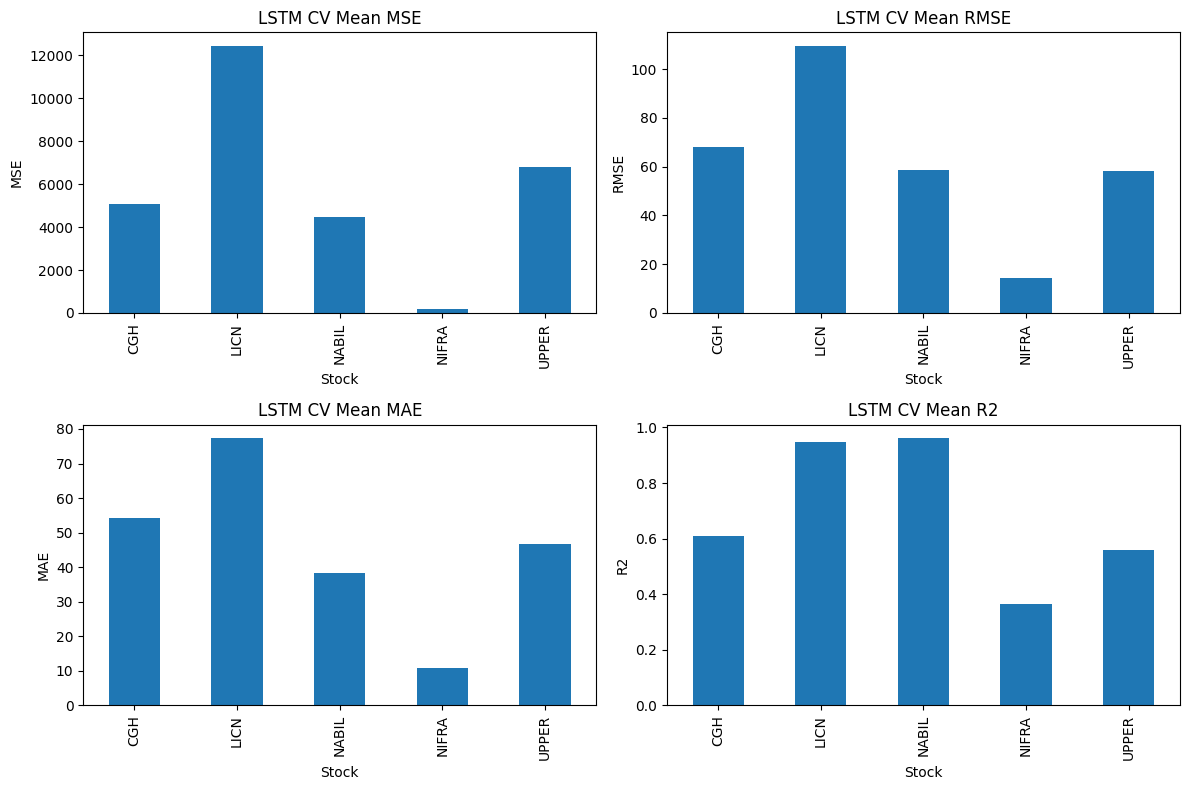

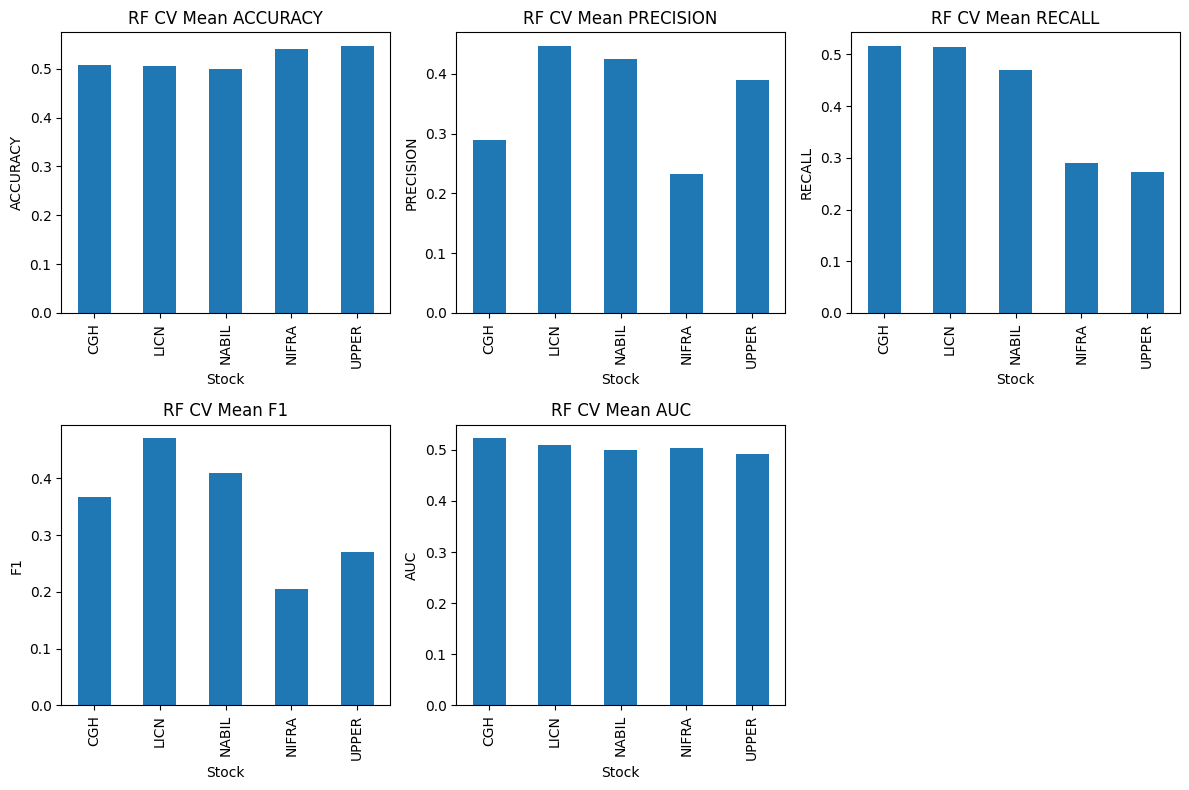

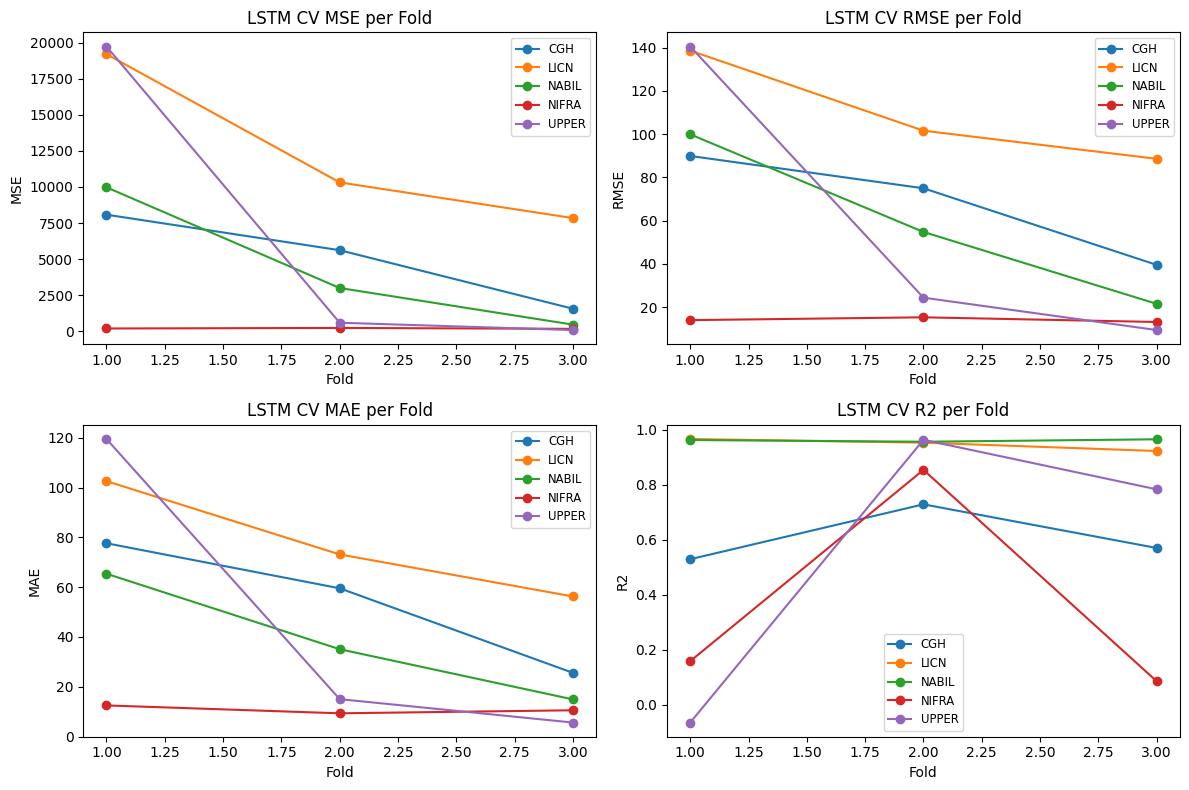

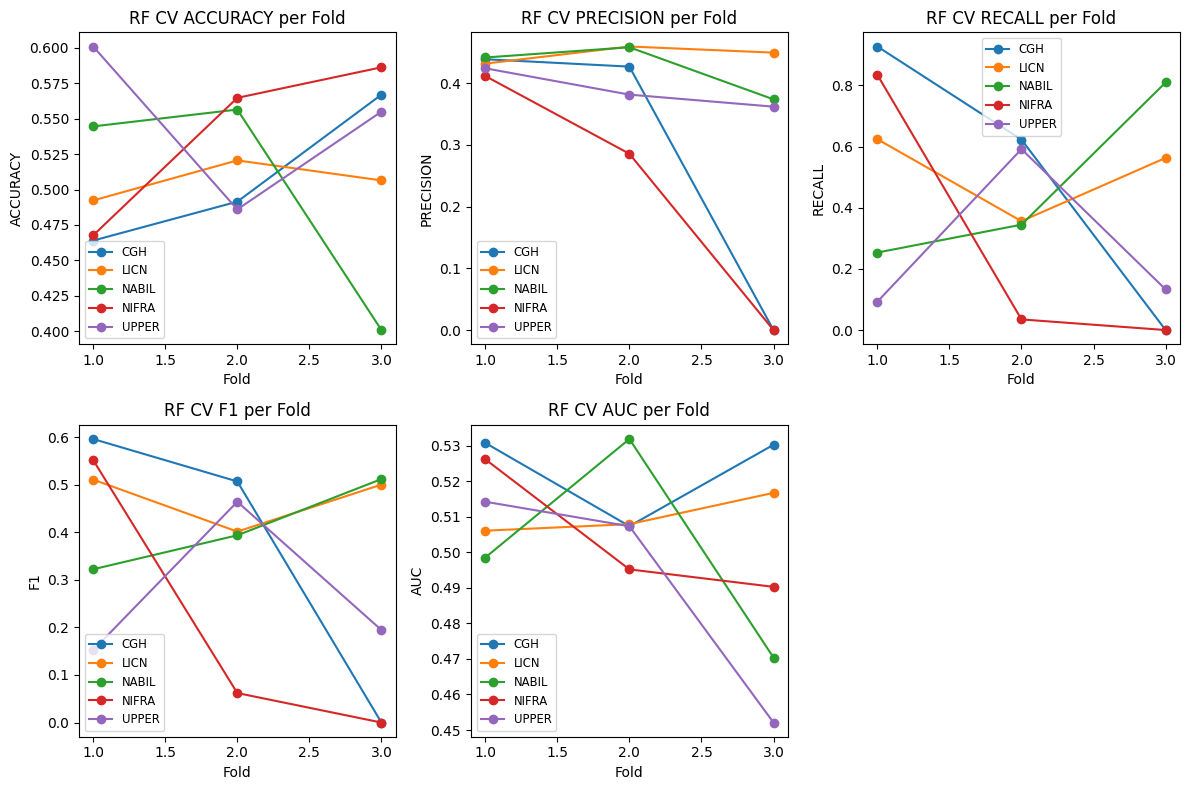

In [ ]:
# Visualize CV results (means per stock + per-fold distributions)
lstm_cv_rows = []
rf_cv_rows = []
lstm_fold_rows = []
rf_fold_rows = []

for stock in STOCKS:
    with open(f"{METRIC_DIR}/{stock}_lstm_cv.json", "r") as f:
        lstm_cv = json.load(f)
    with open(f"{METRIC_DIR}/{stock}_rf_cv.json", "r") as f:
        rf_cv = json.load(f)

    lstm_cv_rows.append({"Stock": stock, **lstm_cv["mean"]})
    rf_cv_rows.append({"Stock": stock, **rf_cv["mean"]})

    for fold in lstm_cv["folds"]:
        lstm_fold_rows.append({"Stock": stock, **fold})
    for fold in rf_cv["folds"]:
        rf_fold_rows.append({"Stock": stock, **fold})

lstm_cv_df = pd.DataFrame(lstm_cv_rows).set_index("Stock")
rf_cv_df = pd.DataFrame(rf_cv_rows).set_index("Stock")
lstm_folds_df = pd.DataFrame(lstm_fold_rows)
rf_folds_df = pd.DataFrame(rf_fold_rows)

# Mean bars (LSTM)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, metric in zip(axes.ravel(), ["mse", "rmse", "mae", "r2"]):
    lstm_cv_df[metric].plot(kind="bar", ax=ax, title=f"LSTM CV Mean {metric.upper()}")
    ax.set_xlabel("Stock")
    ax.set_ylabel(metric.upper())
plt.tight_layout()
plt.show()

# Mean bars (RF)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
metrics = ["accuracy", "precision", "recall", "f1", "auc"]
for ax, metric in zip(axes.ravel(), metrics):
    rf_cv_df[metric].plot(kind="bar", ax=ax, title=f"RF CV Mean {metric.upper()}")
    ax.set_xlabel("Stock")
    ax.set_ylabel(metric.upper())
for ax in axes.ravel()[len(metrics):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

# Per-fold distributions (LSTM)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, metric in zip(axes.ravel(), ["mse", "rmse", "mae", "r2"]):
    data = [
        lstm_folds_df[lstm_folds_df["Stock"] == stock][metric].values
        for stock in STOCKS
    ]
    ax.boxplot(data, labels=STOCKS, showmeans=True)
    ax.set_title(f"LSTM CV {metric.upper()} Distribution")
    ax.set_xlabel("Stock")
    ax.set_ylabel(metric.upper())
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

# Per-fold distributions (RF)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, metric in zip(axes.ravel(), metrics):
    data = [
        rf_folds_df[rf_folds_df["Stock"] == stock][metric].values
        for stock in STOCKS
    ]
    ax.boxplot(data, labels=STOCKS, showmeans=True)
    ax.set_title(f"RF CV {metric.upper()} Distribution")
    ax.set_xlabel("Stock")
    ax.set_ylabel(metric.upper())
    ax.tick_params(axis="x", rotation=45)
for ax in axes.ravel()[len(metrics):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [11]:
rows = []

for stock in STOCKS:
    data = pd.read_json(f"{METRIC_DIR}/{stock}_regression_curve.json")

    mse = mean_squared_error(data["actual"], data["predicted"])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["actual"], data["predicted"])
    r2 = r2_score(data["actual"], data["predicted"])

    rows.append({
        "Stock": stock,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

lstm_table = pd.DataFrame(rows)
lstm_table.to_json(f"{METRIC_DIR}/lstm_table.json", orient="records")
lstm_table

,Stock,MSE,RMSE,MAE,R2
0,CGH,3353.591147,57.910199,48.824495,0.339159
1,LICN,9219.208642,96.016710,57.016520,0.937123
2,NABIL,245.325663,15.662875,12.264642,0.887088
3,NIFRA,53.597738,7.321048,5.235290,0.602021
4,UPPER,30.323774,5.506703,4.602641,0.781177
